# Module 2 Final Project
### Rich Caputo

In this notebook, we will examine the Northwind database and attempt to answer the question:

**Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?** In addition to three other questions which we will address later on.

For reference, we have included the ERD below:
<img src='Northwind_ERD.png'>

As a first order of business, let's load the database into python using SQLAlchemy.

In [57]:
# Get relevant packages
import pandas as pd
from sqlalchemy import *
from sqlalchemy.ext.automap import automap_base
import numpy as np 
import matplotlib.pyplot as plt
from pprint import pprint

In [25]:
# Connect with sqlalchemy
engine = create_engine('sqlite:///Northwind_small.sqlite')
conn = engine.connect()

In [26]:
# Get each table name
pprint(engine.table_names())

['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']


We now have access to our database directly. Notice that some tables have slightly different names than what they are labeled as in the ERD - it is always good practice to print table names. In order to answer our first question, we are primarily focused on looking at the following tables:
- OrderDetail
- Product

We need to take a look at the number of orders per product and differentiate between non-discounted and discounted products. The following query should contain all of the data we need for statistical analysis. Let's run this query and import our data into a pandas DataFrame.

In [40]:
# Inspect column names - ensures correct queries
inspector = inspect(engine)
print([x['name'] for x in inspector.get_columns('OrderDetail')])
print([x['name'] for x in inspector.get_columns('Product')])

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']
['Id', 'ProductName', 'SupplierId', 'CategoryId', 'QuantityPerUnit', 'UnitPrice', 'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel', 'Discontinued']


In [48]:
# Query relevant columns
query = """
SELECT 
    p.ProductName, od.UnitPrice, od.Quantity, od.Discount
FROM 
    Product p
    JOIN
    OrderDetail od
    ON 
    p.Id = od.ProductId
"""
df = pd.read_sql_query(query, engine)

In [49]:
df.head()

,ProductName,UnitPrice,Quantity,Discount
0,Queso Cabrales,14.0,12,0.0
1,Singaporean Hokkien Fried Mee,9.8,10,0.0
2,Mozzarella di Giovanni,34.8,5,0.0
3,Tofu,18.6,9,0.0
4,Manjimup Dried Apples,42.4,40,0.0


In [50]:
# Check number of unique products
df.ProductName.nunique()

77

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 5 columns):
ProductName     2155 non-null object
UnitsOnOrder    2155 non-null int64
UnitPrice       2155 non-null float64
Quantity        2155 non-null int64
Discount        2155 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 84.3+ KB


Great! We have all the data we need currently but can always run a new query to get more data if we need it. Let's now get to our hypothesis testing. Our hypothesis is that discounts have no effect on the number of products customers order. Our data currently contains each order along with: 
- Name of product being ordered
- Unit price of that product
- Quantity of product being ordered
- Percentage discount on that order

We need to differentiate between discounted and non-discounted orders. We can do this easily with pandas slicing. We will then take a look at each populations sample statistics.

In [51]:
df_disc, df_ndisc = df.loc[df.Discount > 0], df.loc[df.Discount == 0]

In [52]:
# Discounted Statistics
df_disc.describe()

,UnitPrice,Quantity,Discount
count,838.000000,838.000000,838.000000
mean,26.292363,27.109785,0.144439
std,30.017214,20.771439,0.071808
min,2.000000,1.000000,0.010000
25%,12.500000,12.000000,0.100000
50%,18.000000,20.000000,0.150000
75%,31.230000,36.000000,0.200000
max,263.500000,130.000000,0.250000


In [53]:
# Non-discounted Statistics
df_ndisc.describe()

,UnitPrice,Quantity,Discount
count,1317.000000,1317.000000,1317.0
mean,26.171534,21.715262,0.0
std,29.717354,17.507493,0.0
min,2.000000,1.000000,0.0
25%,12.000000,10.000000,0.0
50%,18.400000,18.000000,0.0
75%,32.800000,30.000000,0.0
max,263.500000,130.000000,0.0


We see that discounted orders have a higher Quantity mean. However, this is not enough information to lead us to reject the null hypothesis. To get a better sense of Quantity distribution, we will extrapolate the PDF's of each population and plot them.

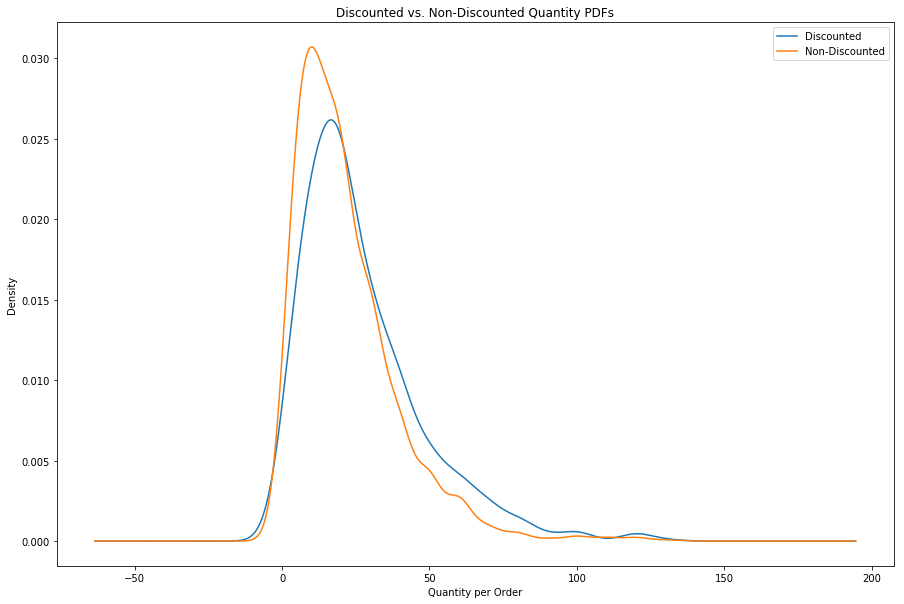

In [62]:
# Plotting
plt.figure(figsize=(15, 10))
df_disc.Quantity.plot.kde(label='Discounted')
df_ndisc.Quantity.plot.kde(label='Non-Discounted')
plt.title('Discounted vs. Non-Discounted Order Quantity PDFs')
plt.xlabel('Quantity per Order')
plt.legend()
plt.show()

It's beginning to look like discounted orders have a slightly different distribution than non-discounted orders. Now, let's formerly phrase our hypothesis test. Let A represent the Quantity population of discounted orders and let B represent the Quantity population of non-discounted orders. 

Null Hypothesis ($H_0$):

$$\mu_A = \mu_B$$

Alternative Hypothesis ($H_1$):

$$\mu_A > \mu_B$$

where $\mu_i$ represents the mean of population i. Notice that this represents a one-sided test since we only care if discounts increase order quantity. To implement our hypothesis test, we will use scipy's ttest_ind function and divide our alpha value by two. We will assume that discounted orders and non-discounted orders are independent samples. Furthermore, we will note that these distributions have unequal variance as this will affect our hypothesis test.

In [67]:
import scipy.stats as stats

# Get two-sample ttest
results = stats.ttest_ind(df_disc.Quantity, df_ndisc.Quantity, equal_var=False)

# pvalue <<< 0.05 reject null hypothesis, quantity mean of Discounted is greater than that of Non-discounted
alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("Reject null hypothesis, mean of Discounted is greater than mean of Non-Discounted")
else:
    print("Accept null hypothesis")

Reject null hypothesis, mean of Discounted is greater than mean of Non-Discounted


Looks like we have a statistically significant difference in population means. Let's see what our t-statistic and p-value actually were.

In [68]:
results

Ttest_indResult(statistic=6.239069142123973, pvalue=5.65641429030433e-10)

Our p-value is very small and our t-statistic is very high - we can affirm with high confidence that these population means are not equal and that in fact discounted orders are on average larger in quantity. Recall that we separated populations based on any discount >0 being different from any order with discount=0.

Let's now consider the monetary affect of discounts. Instead of just looking at quantity, we will generate a new column called 'Revenue' such that 
$$ Revenue = Quantity * Unit Price * (1 - Discount) $$
and perform a t-test using this new metric. This will tell us if Discounts are financially an advantageous strategy. First we will consider a >0 / =0 split as before and then look at different discount thresholds.

In [71]:
df_disc['Revenue'] = df_disc.Quantity * df_disc.UnitPrice * (1 - df_disc.Discount)
df_ndisc['Revenue'] = df_ndisc.Quantity * df_ndisc.UnitPrice * (1 - df_ndisc.Discount)

C:\Users\rcapu\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\rcapu\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We will now look at the sample statistics of these distributions and plot their KDE's. From there we will perform a similar t-test as before!

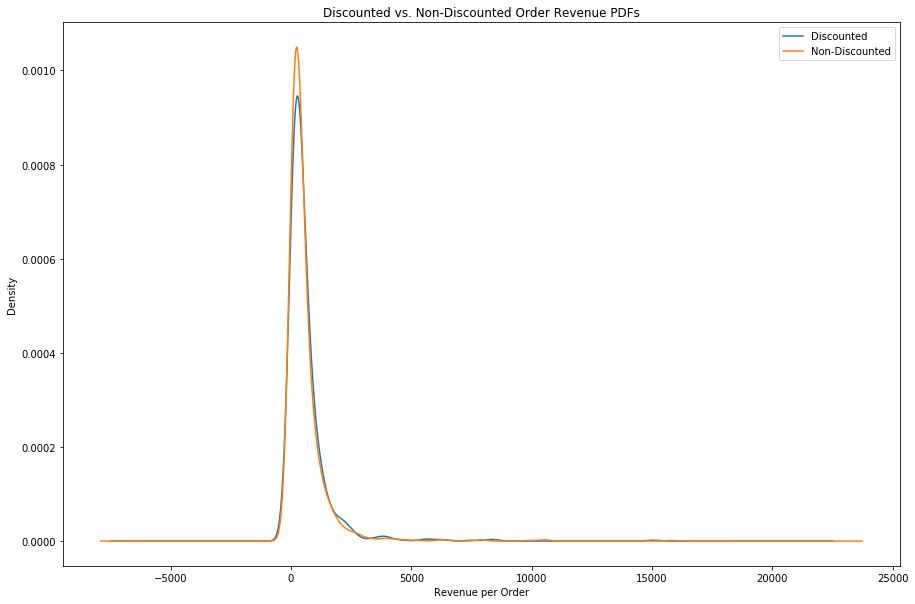

In [73]:
# Plotting
plt.figure(figsize=(15, 10))
df_disc.Revenue.plot.kde(label='Discounted')
df_ndisc.Revenue.plot.kde(label='Non-Discounted')
plt.title('Discounted vs. Non-Discounted Order Revenue PDFs')
plt.xlabel('Revenue per Order')
plt.legend()
plt.show()

Due to the large tails of the Revenue distribution, it is difficult to gain any insight from the above plot. Let's look at the sample statistics of each distribution.

In [75]:
df_disc.Revenue.describe()

count      838.000000
mean       614.671157
std        981.388386
min          8.500000
25%        162.000000
50%        347.775000
75%        693.600000
max      15019.500000
Name: Revenue, dtype: float64

In [76]:
df_ndisc.Revenue.describe()

count     1317.000000
mean       570.006538
std        961.375030
min          4.800000
25%        142.500000
50%        325.000000
75%        640.000000
max      15810.000000
Name: Revenue, dtype: float64

It seems that revenue is larger for discounted orders on average. Let's finally perform a one-sided t-test to confirm if this difference is statistically significant.

In [77]:
# Get two-sample ttest
results = stats.ttest_ind(df_disc.Revenue, df_ndisc.Revenue, equal_var=False)

# pvalue <<< 0.05 reject null hypothesis, quantity mean of Discounted is greater than that of Non-discounted
alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("Reject null hypothesis, mean of Discounted is greater than mean of Non-Discounted")
else:
    print("Accept null hypothesis")

Accept null hypothesis


It seems that this difference is not statistically significant at the 0.05 level. Let's take a look at our results.

In [78]:
results

Ttest_indResult(statistic=1.0381255545690475, pvalue=0.2993546075168257)

In fact, our results have quite a high p-value. It seems that although discounts provide a statistically significant affect on order quantity, they do not have a statistically significant affect on Revenue. Let's see if discount size has any affect. First, we will examine revenue as a function of discount

In [81]:
df['Revenue'] = df.Quantity * df.UnitPrice * (1 - df.Discount)
df.groupby('Discount').Revenue.count()

Discount
0.00    1317
0.01       1
0.02       2
0.03       3
0.04       1
0.05     185
0.06       1
0.10     173
0.15     157
0.20     161
0.25     154
Name: Revenue, dtype: int64

Given that certain discounts are uncommon, let's make a split at the discount = 0.1 level.

In [82]:
df_disc, df_ndisc = df.loc[df.Discount >= 0.1], df.loc[df.Discount < 0.1]

In [83]:
# Get two-sample ttest
results = stats.ttest_ind(df_disc.Revenue, df_ndisc.Revenue, equal_var=False)

# pvalue <<< 0.05 reject null hypothesis, quantity mean of Discounted is greater than that of Non-discounted
alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("Reject null hypothesis, mean of Discounted is greater than mean of Non-Discounted")
else:
    print("Accept null hypothesis")

Accept null hypothesis


In [84]:
results

Ttest_indResult(statistic=-0.6284830250070176, pvalue=0.5297804753579476)